## สำรวจความนิยมของเหล่าไอดอล BNK48 แบบ real-time จาก Twitter's hashtags ด้วย Python

ตัวอย่างแสดงการ streaming และจัดการข้อมูลด้วย PySpark (2.2.0)

## Techical part 0 -- Workflow

ส่วน workflow หลักๆ ก็เหมือนกับการทำ streaming ด้วย Python networking interface ปกตินะครับมาดู โดยมีการเปลี่ยนแปลงโดยการใช้ PySpark ในขั้นตอน Technical part 2 และ Technicla part 3 

1. ดึงข้อมูลจาก Twitter ด้วย Tweepy
2. **Streaming และการจัดการข้อมูล DataFrame ด้วย Pyspark**
3. **จัดลำดับ hashtags และทำหน้าจอแสดงผลแบบ real-time อย่างง่ายๆ**

โดยการใช้ PySpark จะมีประโยชน์เมื่อต้องจัดการข้อมูลขนาดใหญ่เนื่องจากสามารถทำ distributed computation ได้ 

## Techical part 1 -- ดึงข้อมูลจาก Twitter ด้วย Tweepy

ทำการสร้าง script (streamingTwitterTags.py) เพื่อเชื่อมต่อและดึงข้อมูลจาก Twitter อย่างที่แสดงใน blog หลักครับ

## Technical part 2 -- Streaming และการจัดการข้อมูล DataFrame ด้วย Pyspark

สำหรับการ streaming data บน Jupyter Notebook โดยใช้ PySpark ทำได้ดังส่วนข้างล่างครับ

มีกระบวนการโดยสรุปก็คือ
* บรรทัดที่ 6: สร้าง SparkSession
* บรรทัดที่ 9: เชื่อมต่อ streaming socket โดยให้กรอกค่า "host" และ ค่า "port" ที่เราตั้งไว้ใน streamingTwitterTags.py
* บรรทัดที่ 11-23: จัดการข้อมูล twitter streaming โดยค่าบนบรรทัดที่ 22 คือ PySpark DataFrame ที่เรียงลำดับ hashtags ทั้งหมดจากมากลงไปหาน้อยโดยเก็บข้อมูลจาก tweets ทั้งหมดที่มีคำว่า '#bnk48' อยู่ (ตั้งไว้ใน streamingTwitterTags.py)
* บรรทัดที่ 26-27: บันทึกเวลาและเริ่มการ streaming โดยให้ผลลัพธ์บันทึกไว้ใน table ชื่อ "topTagsTable"

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, split, explode, substring, count
from datetime import datetime

# create SparkSession
spark = SparkSession.builder.appName('streamTwitterTags').getOrCreate()

# connect and get tweets
tweets = spark.readStream.format("socket").option("host", "127.0.0.1").option("port", 5555).load()

# convert to lowercase and split the words
words_train = tweets.select(split(lower(tweets.value), " ").alias("value"))

# 'explode' a list of words into rows with single word
words_df = words_train.select(explode(words_train.value).alias('word_explode'))

# keep only rows that the word starts with '#'
hashtags = words_df.filter(substring(words_df.word_explode,0,1)=='#')
hashtags = hashtags.select(hashtags.word_explode.alias('hashtag'))

# count hashtags
count_hashtags = hashtags.groupBy('hashtag').count()
count_hashtags_order = count_hashtags.orderBy(count_hashtags['count'].desc())

# start streaming
start_time = datetime.now()
query = count_hashtags_order.writeStream.outputMode("complete").format("memory").queryName("topTagsTable").start()

เมื่อเรามีทั้ง script สำหรับทำการ streaming tweets (streamingTwitterTags.py) และ script สำหรับจัดการข้อมูลบน Jupyter Notebook แล้ว เราก็พร้อมที่จะทดสอบระบบ โดยเริ่มจากสั่ง run script สำหรับ streaming ก่อน

<img src="https://raw.githubusercontent.com/clumdee/clumdee.github.io/master/assets/img/twitterBNK48/twitterStreaming_run.png" alt="twitterStreaming_run" style="width: 700px;"/>

จากนั้นก็ run code PySpark บน Jupyter Notebook เท่านี้ code ของเราเริ่มดึง tweets จาก Twitter มาจัดการสร้าง DataFrame
ถ้าอยากจะรู้ว่า ณ ขณะนั้นๆ DataFrame ของเราหน้าตาเป็นยังไงก็เรียกดูได้ด้วยคำสั่ง

In [ ]:
spark.sql("select * from topTagsTable").limit(11).show()

ก็จะเป็นการเรียกข้อมูล hashtags 11 ลำดับแรกขึ้นมา ขั้นตอนนี้อาจต้องรอให้เรา run code ไปสักพัก (ไม่กี่วินาทีก็พอ) ก่อนเพื่อให้มีข้อมูลใน DataFrame มาแสดง ไม่งั้นเราก็จะเห็น DataFrame เปล่าๆ

การเห็น DataFrame ออกมาแบบนี้ก็ดีในระดับนึง แต่จะดียิ่งขึ้นถ้าเรานำข้อมูลที่ streaming นี้มาวาด chart ที่ช่วยแสดงผลแบบ real-time

## Technical part 3 -- จัดลำดับ hashtags และทำหน้าจอแสดงผลแบบ real-time อย่างง่ายๆ

เมื่อเรามีตัว PySpark DataFrame แล้ว วิธีที่จะแสดงผลอย่างง่ายก็คือ แปลงข้อมูลเป็น Pandas DataFrame แล้วใช้ที่สุด Pandas+Matplotlib ช่วยทำ chart ครับ โดยเราอยากให้ chart ของเราคอย update เรื่อยๆ ตามช่วงเวลาที่เรากำหนดไว้

ตัว code ก็มีประมาณนี้ครับ

start time: 2018-01-20 13:03:13
current time: 2018-01-20 13:13:20


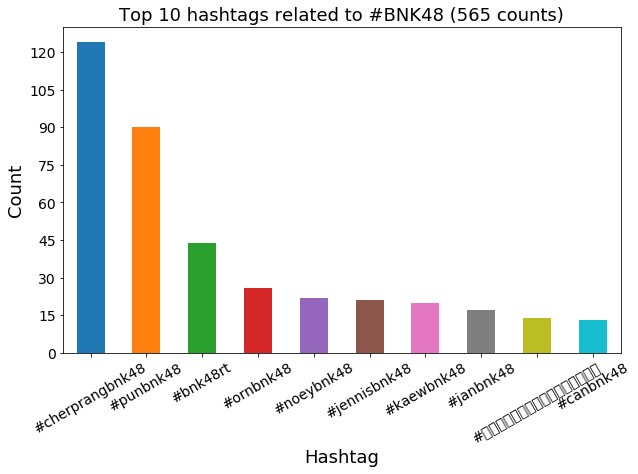

In [2]:
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocatorหลังหลัง
from IPython import display

%matplotlib inline

# set streaming period
stream_period = 10  # in minutes
finish_time = start_time + timedelta(minutes=stream_period)

# interactively query in-memory table
while datetime.now() < finish_time:
    
    # set wait time between iteration
    time.sleep(10)    
    
    # get top hashtags
    top_hashtags_sql = spark.sql("select * from topTagsTable").limit(11)
    
    # convert top hashtags DataFrame to Pandas DataFrame
    top_hashtags = top_hashtags_sql.toPandas()
    
    # number of '#bnk48'
    bnk48_count = top_hashtags[top_hashtags['hashtag']=='#bnk48']['count'].values

    # create bar chart ranking top ten hashtags related to '#bnk48'
    fig, ax = plt.subplots(1,1,figsize=(10,6)) 
    top_hashtags[top_hashtags['hashtag']!='#bnk48'].plot(kind='bar', x='hashtag', y='count', legend=False, ax=ax)
    ax.set_title("Top 10 hashtags related to #BNK48 (%d counts)" % bnk48_count, fontsize=18)
    ax.set_xlabel("Hashtag", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), {"fontsize":14}, rotation=30)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # show only integer yticks
    plt.yticks(fontsize=14)
    
    # clear previous output, print start time and current time, and plot the current chart 
    display.clear_output(wait=True)
    print("start time:", start_time.strftime('%Y-%m-%d %H:%M:%S'))
    print("current time:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    plt.show()
    

ปล. stream เสร็จแล้วก็อย่าลืมไปปิดตัว terminal ที่รัน python script (streamingTwitterTags.py) เชื่อมต่อกับ Twitter API ด้วยนะครับ